# Image Recognition
In this notebook we present the image recognition approach that provides us with a measure for the water level in our tank.

### Base Image
The images within the plant system are obtained automatically by a Raspberry Pi camera that is in a fixed position. Hence, all images are taken from the same angle and position and it is possible to crop the images using fixed values.
Below we see an image as taken by the camera:

<img src="files/system_image.jpg" alt="Photo taken by Rasberry Pi camera showing the system and two water tanks" />

### Parsing
The images are analysed using [`scipy`](https://www.scipy.org/) and [`numpy`](http://www.numpy.org/).
We use [`imageio`](https://imageio.github.io/) to read the image into a numpy array and can then further modify it.

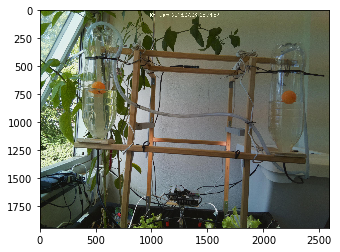

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt  # this is only used to present the output
import imageio

imgpath = "files/system_image.jpg"
# read the image into a numpy array:
image = imageio.imread(imgpath)  

# image is a three-dimensional array (x-coordinates, y-coordinates, colours)
# you can use `image.view()` to get a glimpse of what it looks like

# or you use pyplot to display the image:
plt.imshow(image)

In [2]:
def plot(left, right):
    """
    Since we will be working on both tanks in parallel, we will display the output of both side-by-side.
    This function creates two subfigures and places them next to each other. 
    It's only a small helper.
    """
    fig = plt.figure()
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(left)
    ax1.set_title("Left tank")
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(right)
    ax2.set_title("Right tank")

### Cropping
Since we are only interested in the sections of the image images are always static, we can manually crop the image.


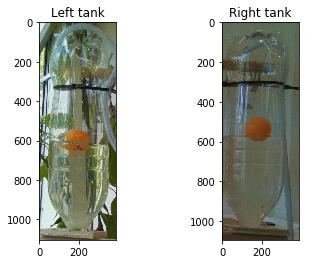

In [3]:
# these values were manually detected
left_crop = dict(topleft=(330,96), bottomright=(720,1200))
right_crop = dict(topleft=(2045,240), bottomright=(2430,1335))

# crop images using the coordinates above
cropped_image_left = image[left_crop["topleft"][1]:left_crop["bottomright"][1],
                        left_crop["topleft"][0]:left_crop["bottomright"][0], :]

cropped_image_right = image[right_crop["topleft"][1]:right_crop["bottomright"][1],
                        right_crop["topleft"][0]:right_crop["bottomright"][0], :]

# plot
plot(cropped_image_left, cropped_image_right)

### Red-Green filtering

### Binarisation

### Median detection